In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Total images found: 1002

Sample entries:
     filename identity  age
0  001A02.JPG      001    2
1  001A05.JPG      001    5
2  001A08.JPG      001    8
3  001A10.JPG      001   10
4  001A14.JPG      001   14

Image count per identity:
identity
001    15
002    16
003    12
004    12
005    11
       ..
078    16
079    14
080    14
081    12
082    11
Name: count, Length: 82, dtype: int64


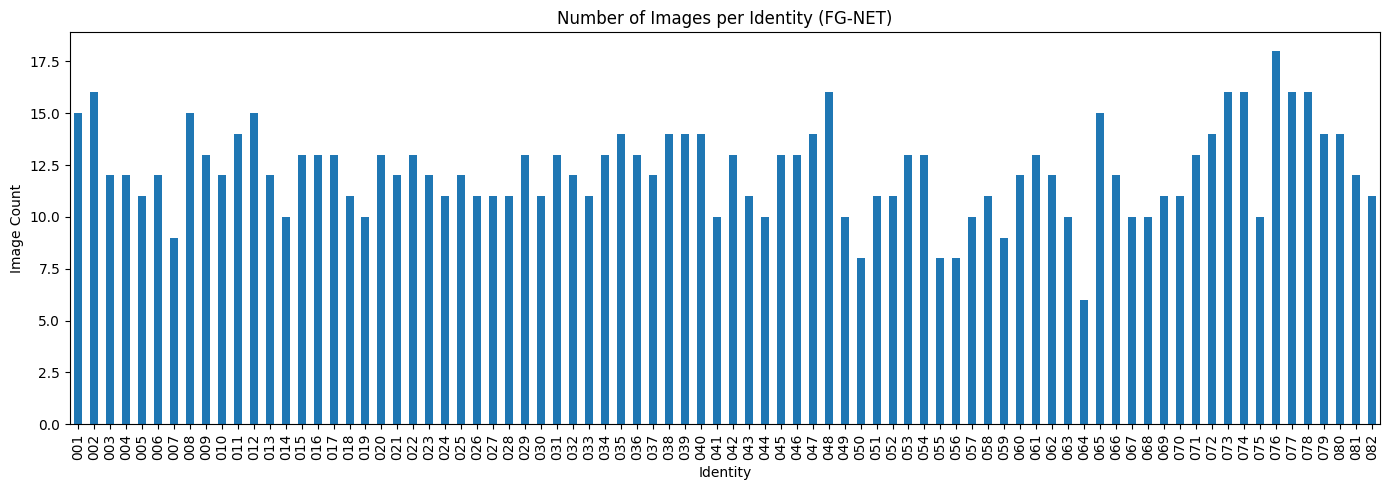

In [1]:
import os
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

fgnet_path = "/kaggle/input/fgnet-dataset/FGNET/images"

all_files = sorted([f for f in os.listdir(fgnet_path) if f.endswith('.JPG')])

print(f"Total images found: {len(all_files)}")

identity_dict = defaultdict(list)
data_rows = []

for file in all_files:
    try:
        identity = file[:3]  # e.g., '001'
        age = int(file[4:6])  # e.g., '29' in 001A29.JPG
        identity_dict[identity].append(file)
        data_rows.append({'filename': file, 'identity': identity, 'age': age})
    except Exception as e:
        print(f"Skipping file: {file} due to error: {e}")

df_fgnet = pd.DataFrame(data_rows)
print("\nSample entries:")
print(df_fgnet.head())

identity_counts = df_fgnet['identity'].value_counts().sort_index()
print("\nImage count per identity:")
print(identity_counts)

plt.figure(figsize=(14, 5))
identity_counts.plot(kind='bar')
plt.title("Number of Images per Identity (FG-NET)")
plt.xlabel("Identity")
plt.ylabel("Image Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [2]:
import os
import random
from collections import defaultdict
import pandas as pd
from itertools import combinations

fgnet_path = "/kaggle/input/fgnet-dataset/FGNET/images"

all_files = sorted([f for f in os.listdir(fgnet_path) if f.endswith('.JPG')])

identity_to_images = defaultdict(list)
for file in all_files:
    identity = file[:3]  # e.g., '001'
    identity_to_images[identity].append(file)

positive_pairs = []
for identity, files in identity_to_images.items():
    if len(files) < 2:
        continue
    for img1, img2 in combinations(files, 2):
        positive_pairs.append((os.path.join(fgnet_path, img1),
                               os.path.join(fgnet_path, img2), 1))

negative_pairs = []
identities = list(identity_to_images.keys())

while len(negative_pairs) < len(positive_pairs):
    id1, id2 = random.sample(identities, 2)
    img1 = random.choice(identity_to_images[id1])
    img2 = random.choice(identity_to_images[id2])
    negative_pairs.append((os.path.join(fgnet_path, img1),
                           os.path.join(fgnet_path, img2), 0))

all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

fgnet_pairs_df = pd.DataFrame(all_pairs, columns=["image1", "image2", "label"])
fgnet_pairs_df.to_csv("/kaggle/working/fgnet_pairs.csv", index=False)

print(f"Total Positive Pairs: {len(positive_pairs)}")
print(f"Total Negative Pairs: {len(negative_pairs)}")
print("Saved as fgnet_pairs.csv in /kaggle/working/")


Total Positive Pairs: 5808
Total Negative Pairs: 5808
Saved as fgnet_pairs.csv in /kaggle/working/


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pandas as pd
import csv

class PairDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.transform = transform
        self.pairs = pd.read_csv(csv_path).values.tolist()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path1, path2, label = self.pairs[idx]
        img1 = Image.open(path1).convert("RGB")
        img2 = Image.open(path2).convert("RGB")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(float(label))

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=512):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, feat1, feat2):
        x = torch.cat((feat1, feat2), dim=1)
        return self.net(x)

pair_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = PairDataset("/kaggle/working/fgnet_pairs.csv", transform=pair_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet.eval().to(device)
for param in resnet.parameters():
    param.requires_grad = False

mlp = MLPClassifier(input_dim=512).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    mlp.train()
    running_loss = 0.0
    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        with torch.no_grad():
            feat1 = resnet(img1)
            feat2 = resnet(img2)
        logits = mlp(feat1, feat2).squeeze(1)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    mlp.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            feat1 = resnet(img1)
            feat2 = resnet(img2)
            logits = mlp(feat1, feat2).squeeze(1)
            val_loss += criterion(logits, labels).item()
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total if total > 0 else 0

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_acc:.2f}%")

print("✅ ResNet18 + MLP training on FG-NET complete.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


Epoch 1/10 | Train Loss: 0.6275 | Val Loss: 0.5999 | Val Accuracy: 67.73%
Epoch 2/10 | Train Loss: 0.5819 | Val Loss: 0.5730 | Val Accuracy: 68.42%
Epoch 3/10 | Train Loss: 0.5500 | Val Loss: 0.5557 | Val Accuracy: 70.70%
Epoch 4/10 | Train Loss: 0.5230 | Val Loss: 0.5493 | Val Accuracy: 71.21%
Epoch 5/10 | Train Loss: 0.5010 | Val Loss: 0.5279 | Val Accuracy: 72.59%
Epoch 6/10 | Train Loss: 0.4731 | Val Loss: 0.5114 | Val Accuracy: 73.67%
Epoch 7/10 | Train Loss: 0.4506 | Val Loss: 0.5140 | Val Accuracy: 75.00%
Epoch 8/10 | Train Loss: 0.4332 | Val Loss: 0.4970 | Val Accuracy: 75.56%
Epoch 9/10 | Train Loss: 0.4173 | Val Loss: 0.6278 | Val Accuracy: 71.08%
Epoch 10/10 | Train Loss: 0.4000 | Val Loss: 0.5402 | Val Accuracy: 73.88%
✅ ResNet18 + MLP training on FG-NET complete.


In [4]:
effnet = models.efficientnet_b0(pretrained=True)
effnet.classifier = nn.Identity()
effnet.eval().to(device)
for param in effnet.parameters():
    param.requires_grad = False

class MLPEffNet(nn.Module):
    def __init__(self, input_dim=1280):
        super(MLPEffNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, feat1, feat2):
        x = torch.cat((feat1, feat2), dim=1)
        return self.net(x)

mlp = MLPEffNet().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    mlp.train()
    train_loss = 0.0
    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        with torch.no_grad():
            feat1 = effnet(img1)
            feat2 = effnet(img2)
        logits = mlp(feat1, feat2).squeeze(1)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    mlp.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            feat1 = effnet(img1)
            feat2 = effnet(img2)
            logits = mlp(feat1, feat2).squeeze(1)
            val_loss += criterion(logits, labels).item()
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total if total > 0 else 0

    print(f"[EffNet] Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s] 


[EffNet] Epoch 1/10 | Train Loss: 0.5789 | Val Loss: 0.5344 | Val Acc: 72.81%
[EffNet] Epoch 2/10 | Train Loss: 0.4762 | Val Loss: 0.4886 | Val Acc: 75.95%
[EffNet] Epoch 3/10 | Train Loss: 0.4044 | Val Loss: 0.4726 | Val Acc: 76.94%
[EffNet] Epoch 4/10 | Train Loss: 0.3490 | Val Loss: 0.5363 | Val Acc: 76.25%
[EffNet] Epoch 5/10 | Train Loss: 0.2957 | Val Loss: 0.5130 | Val Acc: 77.37%
[EffNet] Epoch 6/10 | Train Loss: 0.2459 | Val Loss: 0.5002 | Val Acc: 78.14%
[EffNet] Epoch 7/10 | Train Loss: 0.1967 | Val Loss: 0.5534 | Val Acc: 78.74%
[EffNet] Epoch 8/10 | Train Loss: 0.1621 | Val Loss: 0.5534 | Val Acc: 79.13%
[EffNet] Epoch 9/10 | Train Loss: 0.1284 | Val Loss: 0.6503 | Val Acc: 79.56%
[EffNet] Epoch 10/10 | Train Loss: 0.1042 | Val Loss: 0.6097 | Val Acc: 80.55%


In [5]:
from torchvision import models

vgg = models.vgg19(pretrained=True)
vgg.classifier = nn.Sequential(*[nn.Identity() for _ in vgg.classifier])
vgg.eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False

class MLPVGG(nn.Module):
    def __init__(self, input_dim=25088):
        super(MLPVGG, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, feat1, feat2):
        x = torch.cat((feat1, feat2), dim=1)
        return self.net(x)

mlp = MLPVGG().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    mlp.train()
    train_loss = 0.0
    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        with torch.no_grad():
            feat1 = vgg(img1)
            feat2 = vgg(img2)
        logits = mlp(feat1, feat2).squeeze(1)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    mlp.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            feat1 = vgg(img1)
            feat2 = vgg(img2)
            logits = mlp(feat1, feat2).squeeze(1)
            val_loss += criterion(logits, labels).item()
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total if total > 0 else 0

    print(f"[VGG19] Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 200MB/s]  


[VGG19] Epoch 1/10 | Train Loss: 0.6299 | Val Loss: 0.6156 | Val Acc: 67.47%
[VGG19] Epoch 2/10 | Train Loss: 0.5201 | Val Loss: 0.5931 | Val Acc: 68.98%
[VGG19] Epoch 3/10 | Train Loss: 0.4332 | Val Loss: 0.5485 | Val Acc: 72.59%
[VGG19] Epoch 4/10 | Train Loss: 0.3499 | Val Loss: 0.6205 | Val Acc: 74.66%
[VGG19] Epoch 5/10 | Train Loss: 0.2890 | Val Loss: 0.6308 | Val Acc: 76.46%
[VGG19] Epoch 6/10 | Train Loss: 0.2356 | Val Loss: 0.6187 | Val Acc: 77.58%
[VGG19] Epoch 7/10 | Train Loss: 0.1995 | Val Loss: 0.6307 | Val Acc: 77.93%
[VGG19] Epoch 8/10 | Train Loss: 0.1607 | Val Loss: 0.7663 | Val Acc: 78.79%
[VGG19] Epoch 9/10 | Train Loss: 0.1449 | Val Loss: 0.7679 | Val Acc: 78.66%
[VGG19] Epoch 10/10 | Train Loss: 0.1251 | Val Loss: 0.9400 | Val Acc: 78.70%


In [6]:
from torchvision.models import vit_b_16

vit = vit_b_16(pretrained=True)
vit.heads = nn.Identity()
vit.eval().to(device)
for param in vit.parameters():
    param.requires_grad = False

class MLPViT(nn.Module):
    def __init__(self, input_dim=768):
        super(MLPViT, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, feat1, feat2):
        x = torch.cat((feat1, feat2), dim=1)
        return self.net(x)

mlp = MLPViT().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    mlp.train()
    train_loss = 0.0
    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        with torch.no_grad():
            feat1 = vit(img1)
            feat2 = vit(img2)
        logits = mlp(feat1, feat2).squeeze(1)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    mlp.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            feat1 = vit(img1)
            feat2 = vit(img2)
            logits = mlp(feat1, feat2).squeeze(1)
            val_loss += criterion(logits, labels).item()
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total if total > 0 else 0

    print(f"[ViT-B16] Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 194MB/s] 


[ViT-B16] Epoch 1/10 | Train Loss: 0.5578 | Val Loss: 0.5061 | Val Acc: 74.70%
[ViT-B16] Epoch 2/10 | Train Loss: 0.4440 | Val Loss: 0.4721 | Val Acc: 78.27%
[ViT-B16] Epoch 3/10 | Train Loss: 0.3784 | Val Loss: 0.4650 | Val Acc: 78.44%
[ViT-B16] Epoch 4/10 | Train Loss: 0.3272 | Val Loss: 0.4885 | Val Acc: 78.27%
[ViT-B16] Epoch 5/10 | Train Loss: 0.2720 | Val Loss: 0.4545 | Val Acc: 80.42%
[ViT-B16] Epoch 6/10 | Train Loss: 0.2249 | Val Loss: 0.4853 | Val Acc: 80.51%
[ViT-B16] Epoch 7/10 | Train Loss: 0.1846 | Val Loss: 0.5003 | Val Acc: 81.33%
[ViT-B16] Epoch 8/10 | Train Loss: 0.1454 | Val Loss: 0.5963 | Val Acc: 81.41%
[ViT-B16] Epoch 9/10 | Train Loss: 0.1309 | Val Loss: 0.5876 | Val Acc: 80.81%
[ViT-B16] Epoch 10/10 | Train Loss: 0.0935 | Val Loss: 0.6644 | Val Acc: 80.08%
